In [1]:
import sys, os, pickle
sys.path.append('/home/om2382/vanilla-rtrl/')
from cluster import *
from continual_learning import *
from core import *
from dynamics import *
from functions import *
from gen_data import * 
from learning_algorithms import *
from optimizers import *
from plotting import *
from wrappers import *
import matplotlib.pyplot as plt
from scipy.ndimage.filters import uniform_filter1d

In [2]:
root_name = 'Fig_2_S1_RFLO_Variations_Result'
signal_dicts, result = unpack_cross_compare_result(root_name, checkpoint_stats={'n_nodes': get_checkpoint_n_stable_FPs,
                                                                        'test_loss': get_checkpoint_loss,
                                                                        'spectral_radius': get_checkpoint_spectral_radius,
                                                                        'w_std': get_checkpoint_weight_std,
                                                                        'w_dim': get_checkpoint_W_rec_dim},
                                                   relative_weight_change=False,
                                                   multi_job_comp=False,
                                                   results_subdir='PNAS_Paper')

In [3]:
root_name = 'Fig_2_S1_RFLO_Variations_Result'
results_dir = '/home/om2382/learning-dynamics/results/PNAS_Paper'
analysis_jobs = [j for j in os.listdir(results_dir) if root_name in j and 'analyze' in j]
checkpoints_dicts = {}
for job_name in analysis_jobs:
    indices, checkpoints = unpack_analysis_results(os.path.join(results_dir, job_name))
    checkpoints_dicts[job_name] = {'indices': indices,
                                   'checkpoints': checkpoints}

In [4]:
### --- Calculate stage transition points --- ###

signal_keys_ordered = [k for k in signal_dicts.keys()]
dict_of_stage_assignments = {}
dict_of_t_stage_transitions = {}
for signal_key in signal_keys_ordered:
    signals = signal_dicts[signal_key]
    loss, d_top = signals['test_loss'], signals['aligned_graph_distances']
    stage_assignments, t_stage_transitions = assign_time_points_to_stages(loss, d_top,
                                                                          performance_criterion=0.05,
                                                                          topological_criterion=0.1,
                                                                          loss_window=1,
                                                                          topological_window=20)
    dict_of_stage_assignments[signal_key] = stage_assignments
    dict_of_t_stage_transitions[signal_key] = t_stage_transitions

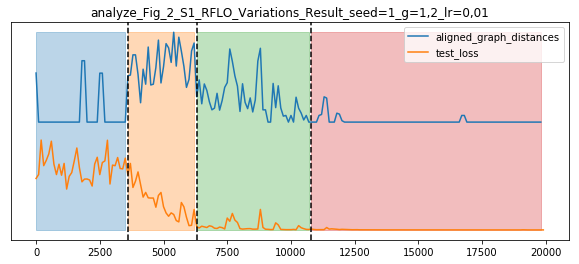

In [6]:
### --- Inspect individual training runs --- ###

i_analysis = 9
for i_analysis in [i_analysis]:
    key = signal_keys_ordered[i_analysis]
    indices = checkpoints_dicts[key]['indices']
    fig = plot_signals(signal_dicts[key], x_values=indices, signal_clips={}, legend=True,
                       key_restriction=['aligned_graph_distances', 'test_loss'],
                       stage_assignments=dict_of_stage_assignments[key])
    for t in dict_of_t_stage_transitions[key]:
        if t is not None:
            plt.axvline(indices[t], color='k', linestyle='--')
    plt.title(key)

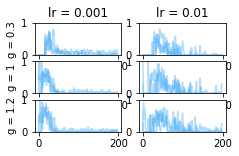

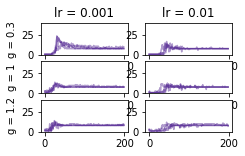

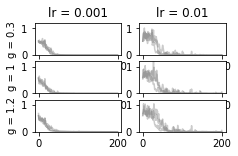

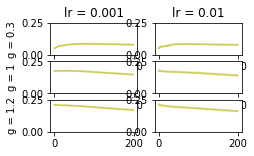

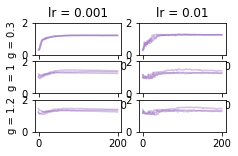

In [7]:
### --- GENERATE FIGURE S1A-C PLOT ALL RESULTS BY CURVE --- ###

sig = 'aligned_graph_distances'
colors_dict = {'aligned_graph_distances': '#3FA9F5',
               'n_nodes': '#3A0882',
               'test_loss': '#7F7F7F',
               'w_std': 'C8',
               'spectral_radius': 'C4'}
y_lim_dict = {'aligned_graph_distances': 1,
              'n_nodes': 40,
              'test_loss': 1.2,
              'w_std': 0.25,
              'spectral_radius': 2}
for sig in colors_dict.keys():
    fig = plot_array_of_signals(signal_dicts, root_name=root_name, signal_keys=[sig] ,alpha=0.4,
                                colors=[colors_dict[sig]],
                                return_fig=True, fig_length=2, swap_order=False, common_ylim=[0, y_lim_dict[sig]])
    #for i in range(6):
        #fig.axes[i].axis('off')
        #fig.axes[i].set_title('')
    figs_path = 'figs'
    fig_name = 'RFLO_Variations_raw_{}'.format(sig)
    #fig.savefig(os.path.join(figs_path, fig_name + '.pdf'), format='pdf')

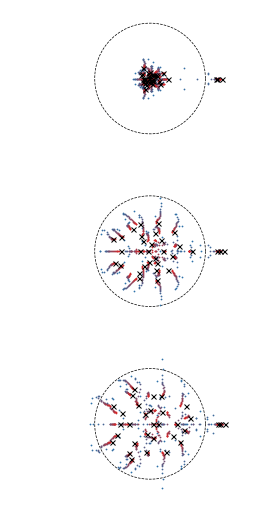

In [42]:
### --- GENERATE FIGURE S1D --- ###
net1 = checkpoints_dicts['analyze_Fig_2_S1_RFLO_Variations_Result_seed=1_g=0,3_lr=0,01']
net2 = checkpoints_dicts['analyze_Fig_2_S1_RFLO_Variations_Result_seed=1_g=1_lr=0,01']
net3 = checkpoints_dicts['analyze_Fig_2_S1_RFLO_Variations_Result_seed=1_g=1,2_lr=0,01']
nets = [net1, net2, net3]
cm = 1/2.54
fig, ax = plt.subplots(3, 1, figsize=(4, 9))
theta = np.arange(0, 2*np.pi, 0.01)
for i_net, net in enumerate(nets):
    ax[i_net].plot(np.cos(theta), np.sin(theta), color='k', linestyle='--', linewidth=0.7)
    ax[i_net].axis('off')
    ax[i_net].axis('equal')
    ax[i_net].set_xlim([-1.3, 1.3])
    ax[i_net].set_ylim([-1.3, 1.3])
    for t in list(range(0, 20000, 1000)) + [19900]:
        W = net['checkpoints']['checkpoint_{}'.format(t)]['rnn'].W_rec
        eigs, vecs = np.linalg.eig(W)
        ax[i_net].plot(eigs.real, eigs.imag, '.', markersize=1.5, color=cols[t//1000])
        if t == 0:
            pass
            #ax[i_net].plot(eigs.real, eigs.imag, 'x', markersize=1, color='k')
        if t == 19900:
            jitter_x = np.random.normal(0, 0.06, W.shape[0])
            jitter_y = np.random.normal(0, 0, W.shape[0])
            ax[i_net].plot(eigs.real+jitter_x, eigs.imag+jitter_y, 'x', markersize=5, color='k')
fig.savefig('figs/figs1_d.pdf')

In [24]:
cols = linearly_interpolate_colors('#2C71A9', '#D32729', 20)

In [13]:
cols

['#2c71a9',
 '#2c70a8',
 '#2d70a7',
 '#2e6fa7',
 '#2f6fa6',
 '#306fa5',
 '#316ea5',
 '#316ea4',
 '#326ea3',
 '#336da3',
 '#346da2',
 '#356ca1',
 '#366ca1',
 '#366ca0',
 '#376b9f',
 '#386b9f',
 '#396b9e',
 '#3a6a9e',
 '#3b6a9d',
 '#3b699c',
 '#3c699c',
 '#3d699b',
 '#3e689a',
 '#3f689a',
 '#406899',
 '#406798',
 '#416798',
 '#426697',
 '#436696',
 '#446696',
 '#456595',
 '#466595',
 '#466594',
 '#476493',
 '#486493',
 '#496392',
 '#4a6391',
 '#4b6391',
 '#4b6290',
 '#4c628f',
 '#4d628f',
 '#4e618e',
 '#4f618d',
 '#50618d',
 '#50608c',
 '#51608c',
 '#525f8b',
 '#535f8a',
 '#545f8a',
 '#555e89',
 '#555e88',
 '#565e88',
 '#575d87',
 '#585d86',
 '#595c86',
 '#5a5c85',
 '#5a5c84',
 '#5b5b84',
 '#5c5b83',
 '#5d5b83',
 '#5e5a82',
 '#5f5a81',
 '#605981',
 '#605980',
 '#61597f',
 '#62587f',
 '#63587e',
 '#64587d',
 '#65577d',
 '#65577c',
 '#66567b',
 '#67567b',
 '#68567a',
 '#69557a',
 '#6a5579',
 '#6a5578',
 '#6b5478',
 '#6c5477',
 '#6d5376',
 '#6e5376',
 '#6f5375',
 '#6f5274',
 '#705274',
 '#7

(0.4099999999999999, 4.590000000000001, 0.0, 0.018775302838029802)

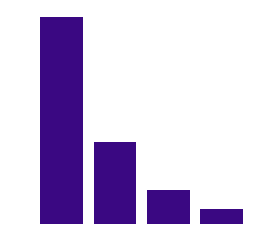

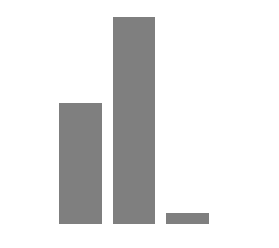

In [9]:
### --- FIGURE 2B CHANGES IN D_SYN AND L BY STAGE --- ###

## -- SYNAPTIC CHANGES -- ##

d_syn_stage_means = np.zeros((len(signal_keys_ordered), 4))
for i_key, key in enumerate(signal_keys_ordered):
    signals = signal_dicts[key]
    SA = dict_of_stage_assignments[key]
    d_syn = signals['rec_weight_distances']
    d_syn_stage_mean = [d_syn[np.where(SA == i_stage)[0]].mean() 
                        for i_stage in range(1, 5)]
    d_syn_stage_means[i_key, :] = np.array(d_syn_stage_mean)
fig = plt.figure(figsize=(4, 4))
plt.bar([1,2,3,4], d_syn_stage_means.mean(0), color='#3A0882')
plt.axis('off')
#fig.savefig('figs/fig2b_dsyn.pdf', dpi=300, format='pdf')

## -- LOSS CHANGES -- ##

d_loss_stage_means = np.zeros((len(signal_keys_ordered), 4))
for i_key, key in enumerate(signal_keys_ordered):
    signals = signal_dicts[key]
    SA = dict_of_stage_assignments[key]
    loss = signals['test_loss']
    d_loss = loss[1:] - loss[:-1]
    d_loss_stage_mean = [d_loss[np.where(SA == i_stage)[0]].mean() 
                         for i_stage in range(1, 5)]
    d_loss_stage_means[i_key, :] = np.array(d_loss_stage_mean)
fig = plt.figure(figsize=(4, 4))
plt.bar([1,2,3,4], -d_loss_stage_means.mean(0), color='#7F7F7F')
plt.axis('off')
#fig.savefig('figs/fig2b_dloss.pdf', dpi=300, format='pdf')

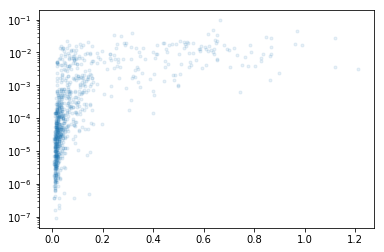

In [12]:
d_syn_stage_means = np.zeros((len(signal_keys_ordered), 4))
d_syn_all = np.array([])
d_loss_all = np.array([])
for i_key, key in enumerate(signal_keys_ordered):
    signals = signal_dicts[key]
    SA = dict_of_stage_assignments[key]
    d_syn = signals['rec_weight_distances']
    d_syn_all = np.concatenate([d_syn_all, d_syn])
    loss = uniform_filter1d(signals['test_loss'], size=10)
    d_loss = loss[1:] - loss[:-1]
    d_loss_all = np.concatenate([d_loss_all, d_loss])
    plt.plot(d_syn, d_loss, '.', color='C0', alpha=0.1)
plt.yscale('log')

In [8]:
from scipy.stats import pearsonr, spearmanr
ccoef = pearsonr(d_syn_all, d_loss_all)

In [9]:
ccoef

(-0.2248176999379765, 2.829300185877213e-42)

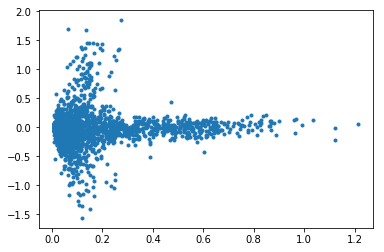

In [38]:
plt.plot(d_syn_all, d_loss_all, '.')

/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: Mean of empty slice.
/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: Mean of empty slice.
/share/apps/anaconda3-2019.03/lib/python3.7/site-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


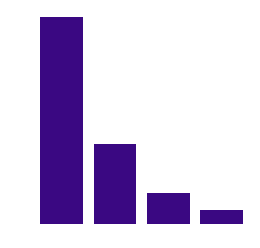

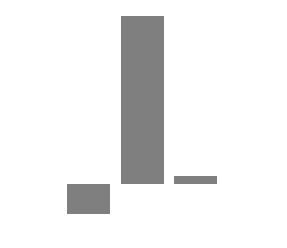

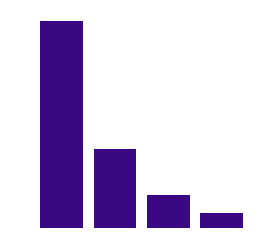

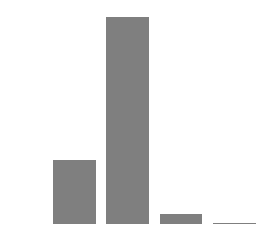

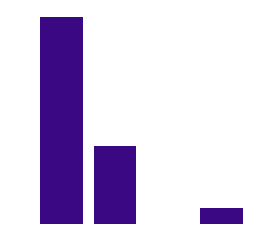

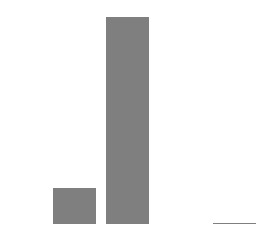

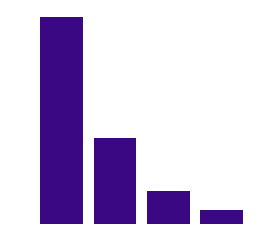

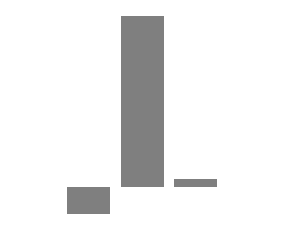

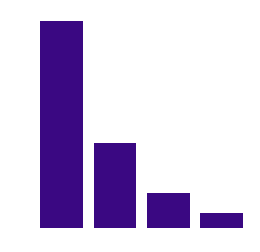

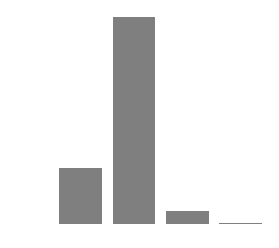

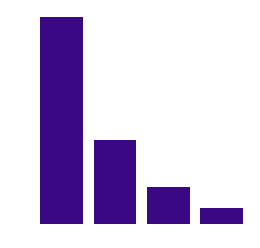

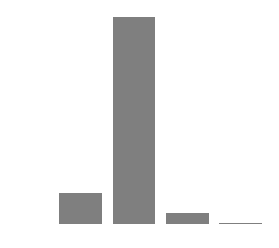

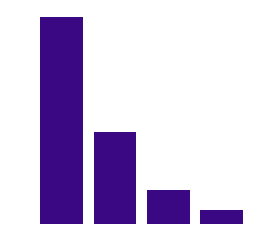

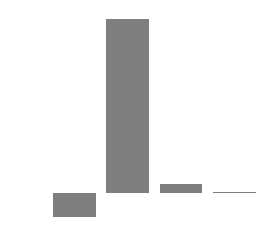

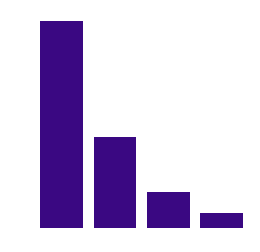

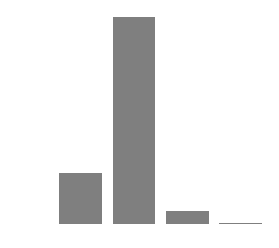

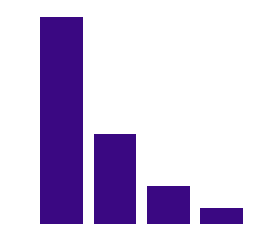

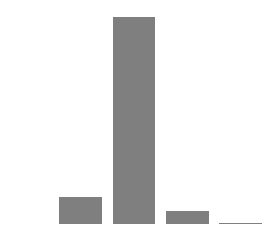

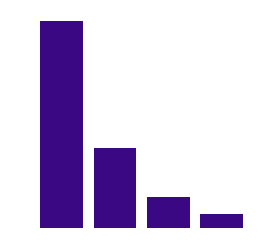

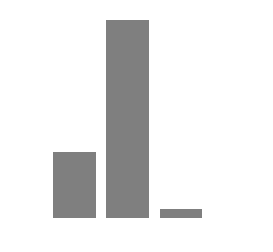

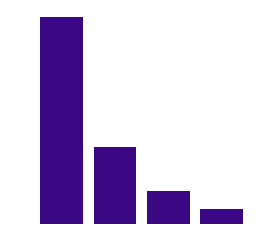

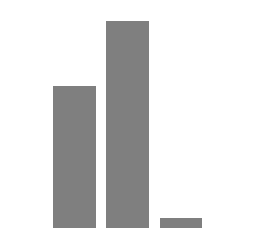

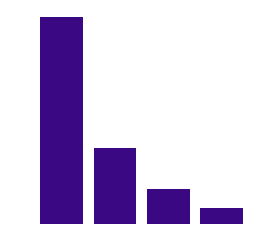

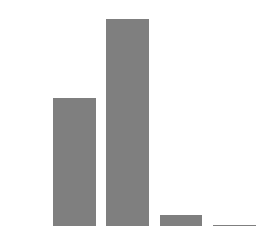

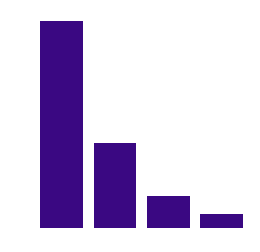

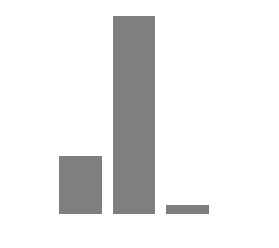

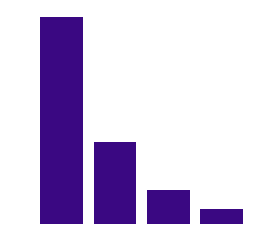

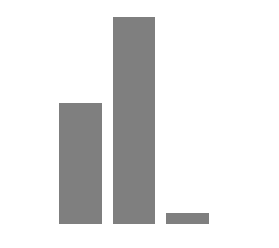

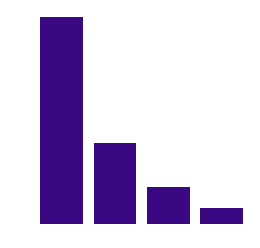

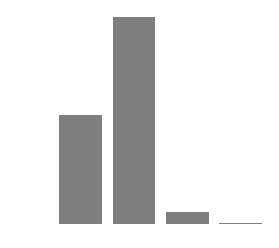

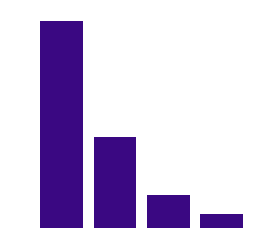

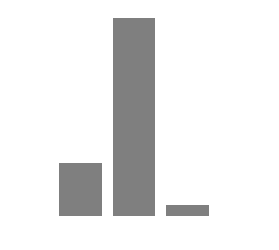

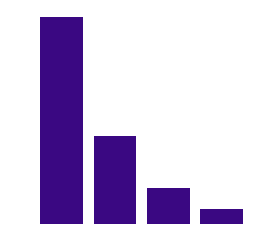

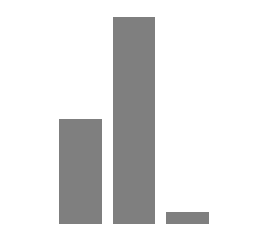

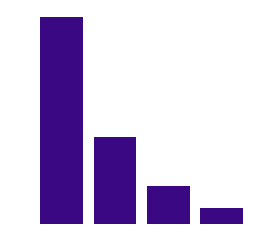

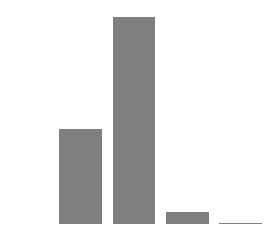

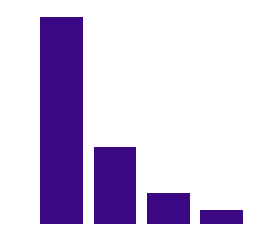

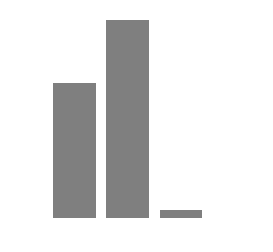

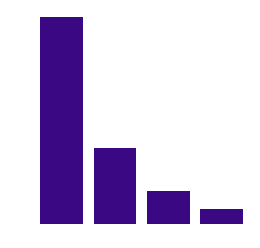

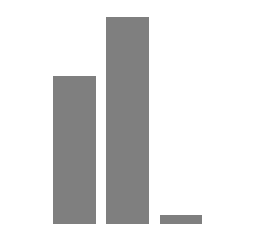

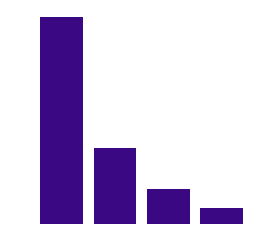

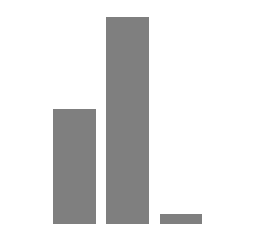

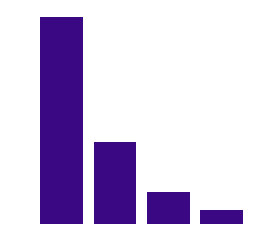

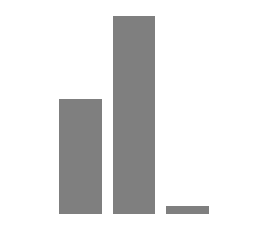

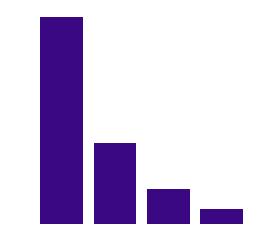

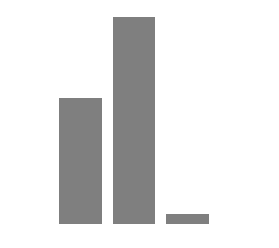

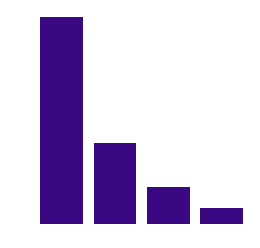

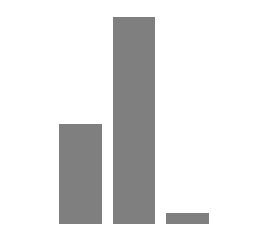

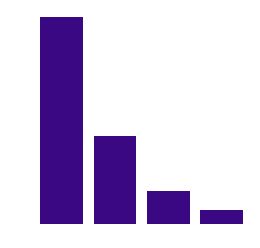

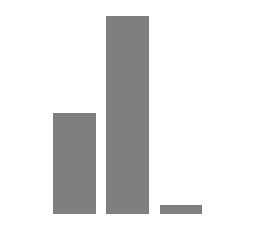

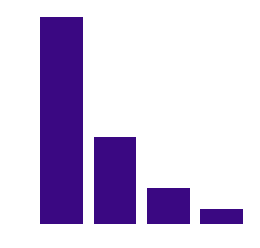

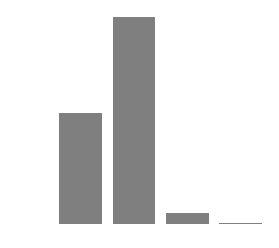

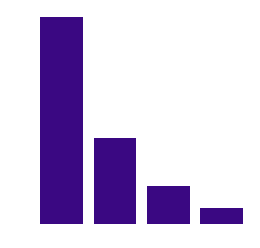

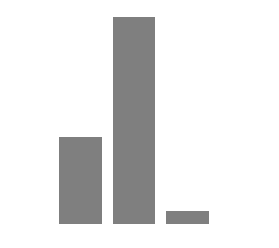

In [11]:
### --- FIGURE S2 ROBUST TO STAGE PARAMETERS --- ###

### --- Calculate stage transition points --- ###

for tw in [15, 20, 25]:
    for pc in [0.03, 0.05, 0.08]:
        for tc in [0.08, 0.1, 0.12]:
            dict_of_stage_assignments = {}
            dict_of_t_stage_transitions = {}
            for signal_key in signal_keys_ordered:
                signals = signal_dicts[signal_key]
                loss, d_top = signals['test_loss'], signals['aligned_graph_distances']
                stage_assignments, t_stage_transitions = assign_time_points_to_stages(loss, d_top,
                                                                                      performance_criterion=pc,
                                                                                      topological_criterion=tc,
                                                                                      loss_window=1,
                                                                                      topological_window=tw)
                dict_of_stage_assignments[signal_key] = stage_assignments
                dict_of_t_stage_transitions[signal_key] = t_stage_transitions
            
            ## -- SYNAPTIC CHANGES -- ##

            d_syn_stage_means = np.zeros((len(signal_keys_ordered), 4))
            for i_key, key in enumerate(signal_keys_ordered):
                signals = signal_dicts[key]
                SA = dict_of_stage_assignments[key]
                d_syn = signals['rec_weight_distances']
                d_syn_stage_mean = [d_syn[np.where(SA == i_stage)[0]].mean() 
                                    for i_stage in range(1, 5)]
                d_syn_stage_means[i_key, :] = np.array(d_syn_stage_mean)
            fig = plt.figure(figsize=(4, 4))
            plt.bar([1,2,3,4], d_syn_stage_means.mean(0), color='#3A0882')
            plt.axis('off')
            figs_path = 'figs/FigS2_Robustness/'
            fig_name = 'figS2_dsyn_tw={}_pc={}_tc={}.pdf'.format(tw, pc, tc)
            #fig.savefig(os.path.join(figs_path, fig_name), dpi=300, format='pdf')

            ## -- LOSS CHANGES -- ##

            d_loss_stage_means = np.zeros((len(signal_keys_ordered), 4))
            for i_key, key in enumerate(signal_keys_ordered):
                signals = signal_dicts[key]
                SA = dict_of_stage_assignments[key]
                loss = signals['test_loss']
                d_loss = loss[1:] - loss[:-1]
                d_loss_stage_mean = [d_loss[np.where(SA == i_stage)[0]].mean() 
                                     for i_stage in range(1, 5)]
                d_loss_stage_means[i_key, :] = np.array(d_loss_stage_mean)
            fig = plt.figure(figsize=(4, 4))
            plt.bar([1,2,3,4], -d_loss_stage_means.mean(0), color='#7F7F7F')
            plt.axis('off')
            fig_name = 'figS2_dsyn_tw={}_pc={}_tc={}.pdf'.format(tw, pc, tc)
            #fig.savefig(os.path.join(figs_path, fig_name), dpi=300, format='pdf')